In [992]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.io
import random

from sklearn.model_selection import cross_val_score

In [993]:
data = pd.read_csv('data/NYU_sleep_df.csv', index_col = 0)

In [994]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52560 entries, 0 to 52559
Columns: 136 entries, 0 to ampm
dtypes: float64(3), int64(133)
memory usage: 54.9 MB
None


,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,trend,time,time_cos,ampm
0,0,1,0,1,1,1,1,1,1,1,...,0,1,0,0,0,1,0.643939,0.000000,1.000000,0
1,0,1,0,1,0,1,1,1,1,1,...,0,1,0,0,0,1,0.628788,0.166667,0.999048,0
2,0,1,0,0,0,1,0,1,1,1,...,0,1,1,0,0,1,0.606061,0.333333,0.996195,0
3,0,1,0,0,0,1,0,1,1,0,...,0,1,1,0,0,1,0.606061,0.500000,0.991445,0
4,0,1,0,1,0,0,0,1,1,0,...,0,1,1,0,0,1,0.545455,0.666667,0.984808,0


In [1009]:
window = 6*24*6
n0 = 120*24*6
n = n0 + 60*24*6 + 6*6
pred_window = 6

infant = '10'

X_train = pd.DataFrame([data[infant].values[i : i + window] for i in range(n0, n - window)])
y_train = pd.DataFrame([sum(data[infant].values[window + i : window + i + pred_window]) for i in range(n0, n - window)])

In [1010]:
X_train['time_of_day'] = data.time
X_train['cos'] = data.time_cos
X_train['AM/PM'] = data.ampm

In [1011]:
for j in range(6, 6*24+1, 6):
    X_train[str(j) + '_10min'] = pd.DataFrame([data[infant].values[i + window - j: i + window].sum() 
                                               for i in range(n0, n)])

In [1012]:
X_train['N_naps_12hrs'] = pd.DataFrame([abs(pd.Series(data[infant].values[i + window - 72: i + window]).diff()).sum()//2 for i in range(n)])

In [1013]:
drop_rows = []
for i in range(X_train.shape[0]):    
    if X_train[window - 1][i] == y_train[0][i] and random.uniform(0, 1) > 1.3:
        drop_rows.append(i)

In [1014]:
X_train.drop(drop_rows, inplace = True)
y_train.drop(drop_rows, inplace = True)

In [1015]:
drop_periods = 0
featuredrop = [window - 1 - i for i in range(drop_periods)]
X_train.drop(featuredrop, axis=1, inplace = True)

In [1016]:
import lightgbm as lgb

lgbm_reg = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=20, max_depth=-1, learning_rate=0.1,
                              n_estimators=250, subsample_for_bin=200000, objective=None, 
                              class_weight=None, min_split_gain=0.0, min_child_weight=0.001, 
                              min_child_samples=20, subsample=1.0, subsample_freq=0, 
                              colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42, 
                              n_jobs = -1, importance_type='split')

#model = SelectFromModel(lgbm_clf, prefit=True)
#train_reduced = model.transform(X_new)
#test_reduced = model.transform(X_test_new)


scores = cross_val_score(lgbm_reg, X_train, y_train.values.reshape(-1), cv=5, error_score="raise")
print(scores)
print('Average score:', scores.mean())

[0.65705401 0.64752028 0.64489313 0.65019042 0.69836731]
Average score: 0.6596050318419466


In [1017]:
lgbm_reg.fit(X_train, y_train.values.reshape(-1))

LGBMRegressor(n_estimators=250, num_leaves=20, random_state=42)

In [1018]:
def prediction(X, weights, window):
    
    if X.shape[0] != 6: 
        print("Wrong input data!")
        return -1
    weights = weights / np.sum(weights)
    
    last_status = X.iloc[-1][window - 1]
    
    if last_status == 1:
        vec = ((lgbm_reg.predict(X).round() - [5, 4, 3, 2, 1, 0]) > 0).astype(int)
        return round(np.dot(vec, weights))
    else:
        vec = ((lgbm_reg.predict(X).round() - [5, 4, 3, 2, 1, 0]) < 1).astype(int)
        return round(1 - np.dot(vec, weights))

In [1019]:
def data_augment(X, prediction, time, window):
    X_c = X.iloc[:, : window]
    X_c = X_c.shift(-1, axis = 1)
    X_c.iloc[0, window-1] = prediction
    X_c.index += 1
    time = time + 24/144
    X_c['time_of_day'] = time
    X_c['cos'] = np.cos(2*np.pi * time / 24)
    if time > 12:
        X_c['AM/PM'] = 1
    else:
        X_c['AM/PM'] = 0
    for j in range(6,6*24+1,6):
        X_c[str(j) + '_10min'] = X_c.values[:, window - j : window].sum()
    #X_c = X.drop(featuredrop, axis=1)
    X_c = X_c.astype(int)
    X_c['N_naps_12hrs'] = pd.Series(X_c.values[:, window - 72: window].flatten()).diff().abs().sum()//2
    
    return X_c

In [1020]:
def update_step(X, weights, window):
    pred = prediction(X, weights, window)
    #timeline = Xtt.iloc[-1,-:window]
    X_c = X[1:]
    new_row = data_augment(X[5:], pred, X[5:].time_of_day.values, window)
    X_c = X_c.append(new_row)
    
    return X_c

In [1027]:
def lgbm_avg_prediction(X, weights, days):
    sleep = np.array(X.iloc[-1, window - 64 : window])
    m = days*6*24

    for i in range(m):
        X = update_step(X, weights, window)
        sleep = np.append(sleep, X.iloc[-1, window - 1])
    
    return sleep

In [1028]:
weights = np.array([1, 1, 1, 1, 1.1, 1.25])
Xtt = X_train[-6:]

sleep = lgbm_avg_prediction(Xtt, weights, 2)

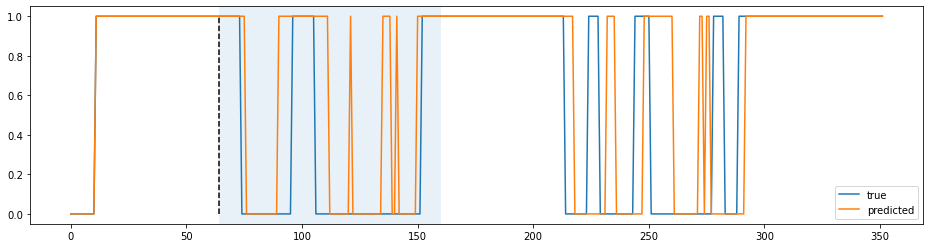

In [1029]:
dff = pd.DataFrame()
dff['true'] = data[infant].values[n - 65: n - 1 + m]
dff['predicted'] = sleep
#dff = dff.set_index(data[infant].index[n0 + window - 30 : n0 + window + m*6], 'time')

dff.plot(figsize=(16,4))
plt.axvspan(64, 64 + 16*6, alpha = 0.1)
plt.vlines(64, 0, 1, colors = 'black', linestyle = '--')

In [19]:
X = pd.DataFrame(data[infant].values[n0 : n0 + window].reshape(1,window))
testX = data_augment(X)

In [38]:
X_train1 = pd.DataFrame([data[infant].values[i : i + window] for i in range(n0, n - window)])
X_train1

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13711,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
13712,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
13713,1,1,1,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
13714,1,1,1,1,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
def next_step(X, clf):
    

In [37]:
X = pd.DataFrame(data[infant].values[n0 : n0 + window].reshape(1,window))
X

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


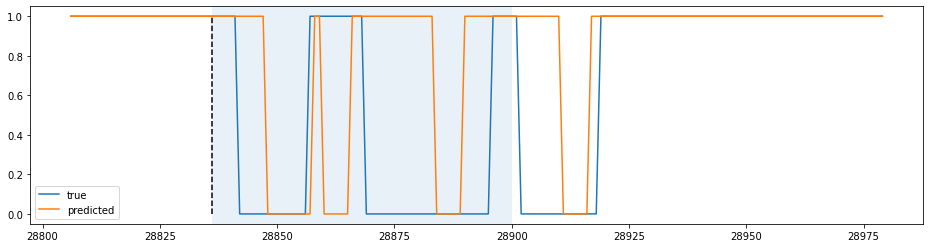

In [121]:
n0 = n-window+0*24*6
X = pd.DataFrame(data[infant].values[n0 : n0 + window].reshape(1,window))
sleep = data[infant].values[n0 : n0 + window]

m = 1*24

for i in range(m):
    
    X_c = data_augment(X)
    
    step = lgbm_clf.predict(X_c)[0]
    X = X.shift(-6, axis = 1)
    
    if X[window - 7].values[0] == 1:
        for k in range(step):
            X[window - 6 + k] = 1
            sleep = np.append(sleep, 1)
        for k in range(step, 6):
            X[window - 6 + k] = 0
            sleep = np.append(sleep, 0)
    elif X[window - 7].values[0] == 0:
        for k in range(step):
            X[window - 6 + k] = 0
            sleep = np.append(sleep, 0)
        for k in range(step, 6):
            X[window - 6 + k] = 1
            sleep = np.append(sleep, 1)

dff = pd.DataFrame()
dff['true'] = data[infant].values[n0 + window - 30 : n0 + window + m*6]
dff['predicted'] = sleep[window - 30:]
dff = dff.set_index(data[infant].index[n0 + window - 30 : n0 + window + m*6], 'time')

dff.plot(figsize=(16,4))
plt.axvspan(n0 + window, n0 + window + 64, alpha = 0.1)
plt.vlines(n0 + window, 0, 1, colors = 'black', linestyle = '--')

In [93]:
X = pd.DataFrame(data[infant].values[n0 : n0 + window].reshape(1,window))
X.shift(-6, axis = 1)[window-7].values[0]==1

True

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
xgb_clf = XGBClassifier(learning_rate=0.0025, n_estimators=4000, 
                        max_depth = 6, min_child_weight=6, subsample=1.0, 
                        colsample_bytree=0.8, use_label_encoder=False, 
                        eval_metric='logloss', random_state = 42)

xgb_clf.fit(X_tr, y_train)
# good parameters: learning_rate=0.0025, n_estimators=4000, max_depth = 6
#model = SelectFromModel(xgb_clf, prefit=True)
#train_reduced = model.transform(X_new)
#test_reduced = model.transform(X_test_new)

scores = cross_val_score(xgb_clf, X_tr, y_train, cv=5)
print(scores)
print('Average score:', scores.mean())

<AxesSubplot:ylabel='feature'>

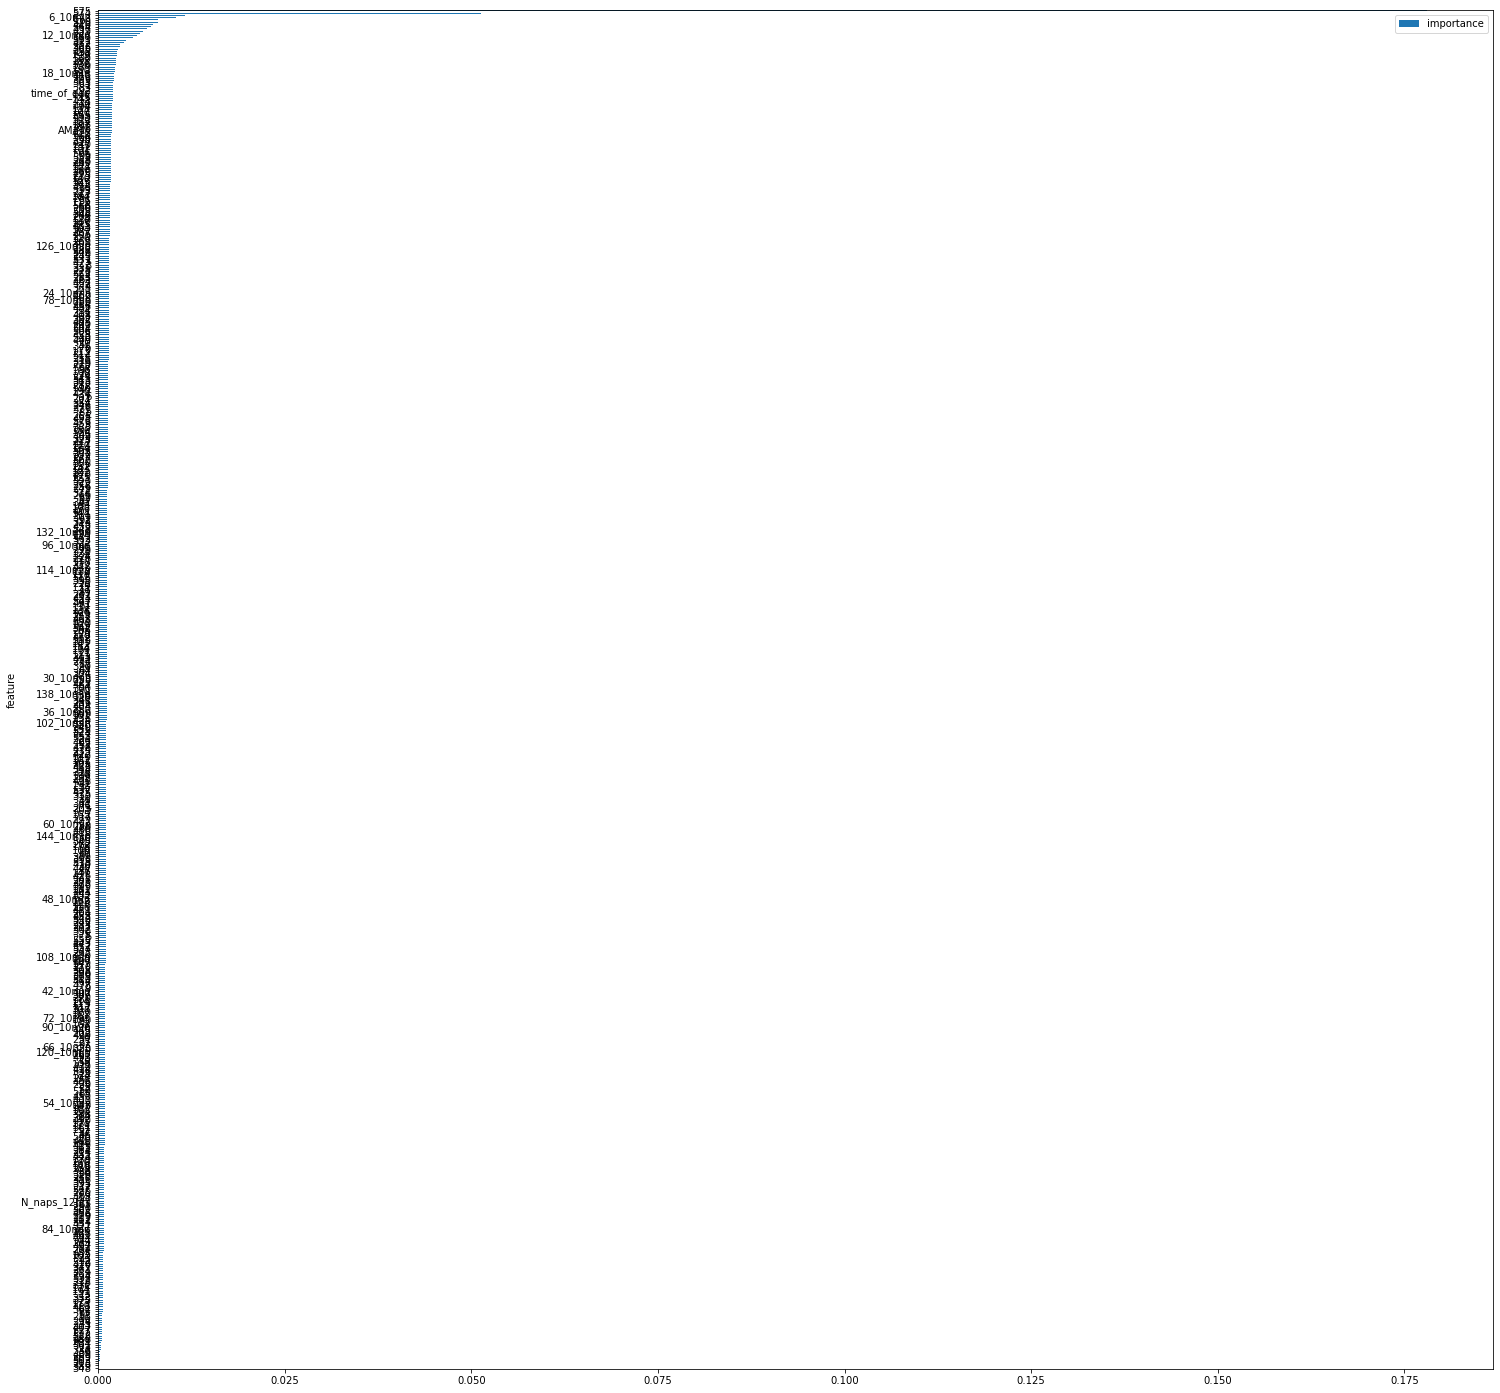

In [99]:
features = pd.DataFrame()
features['feature'] = X_tr.columns
features['importance'] = xgb_clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

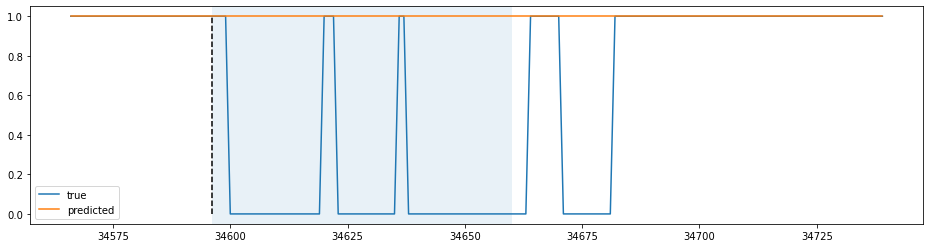

In [100]:
n0 = n-window+0*24*6
X = pd.DataFrame(data[infant].values[n0 : n0 + window].reshape(1,window))
sleep = data[infant].values[n0 : n0 + window]

m = 1*24*6

for i in range(m):
    for j in range(6,6*24+1,6):
        X[str(j) + '_10min'] = X.values[:, - j : window].sum()
    X_c = X.drop(featuredrop, axis=1)
    X_c['N_naps_12hrs'] = pd.Series(X.values[:, window - 72: window].flatten()).diff().abs().sum()//2
    X_c['time'] = data.time[n0 + i : n0 + window + i]
    X_c['time_cos'] = data.time_cos[n0 + i : n0 + window + i]
    X_c['ampm'] = data.ampm[n0 + i : n0 + window + i]
    step = lgbm_clf.predict(X_c).reshape(1,1)[0]
    X = X.shift(-1, axis = 1)
    X[window - 1] = step
    sleep = np.append(sleep, step)
    
dff = pd.DataFrame()
dff['true'] = data[infant].values[n0 + window - 30 : n0 + window + m]
dff['predicted'] = sleep[window - 30:]
dff = dff.set_index(data[infant].index[n0 + window - 30 : n0 + window + m], 'time')

dff.plot(figsize=(16,4))
plt.axvspan(n0 + window, n0 + window + 64, alpha = 0.1)
plt.vlines(n0 + window, 0, 1, colors = 'black', linestyle = '--')

In [288]:
models = [('lgbm', lgbm_clf), ('rf', xgb_clf)]
stacking = StackingClassifier(estimators=models)

scores = cross_val_score(stacking, X_tr, y_train.values.reshape(-1), scoring='accuracy', cv=5)
print(scores)
print(scores.mean())
print(scores.std())

KeyboardInterrupt: 

In [72]:
n0 = n-window+0*24*4
X = pd.DataFrame(data.sleep.values[n0 : n0 + window].reshape(1,window))
sleep = data.sleep.values[n0 : n0 + window]

m = 1*24*4

for i in range(m):
    for j in range(6,6*24+1,6):
        X[str(j) + '_10min'] = X.values[:, - j : window].sum()
    X_c = X.drop(featuredrop, axis=1)
    X_c['N_naps_12hrs'] = pd.Series(X.values[:, window - 72: window].flatten()).diff().abs().sum()//2
    X_c['time_of_day'] = data.time_of_day[n0 + i : n0 + window + i]
    X_c['cos'] = data.cos[n0 + i : n0 + window + i]
    X_c['AM/PM'] = data['AM/PM'][n0 + i : n0 + window + i]
    step = stacking.predict(X_c).reshape(1,1)[0]
    X = X.shift(-1, axis = 1)
    X[window - 1] = step
    sleep = np.append(sleep, step)

AttributeError: 'StackingClassifier' object has no attribute 'final_estimator_'

In [ ]:
dff = pd.DataFrame()
dff['true'] = data.sleep.values[n0 + window - 30 : n0 + window + m]
dff['predicted'] = sleep[window - 30:]
dff = dff.set_index(data.index[n0 + window - 30 : n0 + window + m], 'time')

dff.plot(figsize=(16,4))
plt.axvspan(30, 30 + 64, alpha = 0.1)
plt.vlines(30, 0, 1, colors = 'black', linestyle = '--')